In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf  # Updated import for TensorFlow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Nadam
from tensorflow.keras.regularizers import l1, l2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seed using tf.random.set_seed for TensorFlow 2
tf.random.set_seed(42)

# Rest of your code goes here...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Specify the correct path based on your Google Drive structure
path = "/content/drive/MyDrive/gar"

# Check if the path exists
if os.path.exists(path):
    print("Path exists.")
else:
    print("Path does not exist.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path exists.


In [ ]:
import os

# List contents of the parent directory
parent_directory = "/content/drive/MyDrive/datagar/datagar"
contents = os.listdir(parent_directory)
print(contents)


['plastic', 'trash', 'glass', 'paper', 'cardboard', 'metal']


In [ ]:
import glob

# Specify the correct Google Drive path
data_dir = "/content/drive/MyDrive/datagar/datagar"

# List all subdirectories in the specified path
folders = glob.glob(data_dir + '/*')
print(folders)

# Count the total number of images in all subdirectories
image_cnt = glob.glob(data_dir + '/*/*.jpg')
print(len(image_cnt))



['/content/drive/MyDrive/datagar/datagar/plastic', '/content/drive/MyDrive/datagar/datagar/trash', '/content/drive/MyDrive/datagar/datagar/glass', '/content/drive/MyDrive/datagar/datagar/paper', '/content/drive/MyDrive/datagar/datagar/cardboard', '/content/drive/MyDrive/datagar/datagar/metal']
2549


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 32
IMG_SIZE = [224, 224]

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    shuffle=True,
    batch_size=batch_size,
    image_size=IMG_SIZE,
    seed=123
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    batch_size=batch_size,
    image_size=IMG_SIZE,
    seed=123
)


Found 2549 files belonging to 6 classes.
Using 2040 files for training.
Found 2549 files belonging to 6 classes.
Using 509 files for validation.


In [ ]:
class_names=train_ds.class_names
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

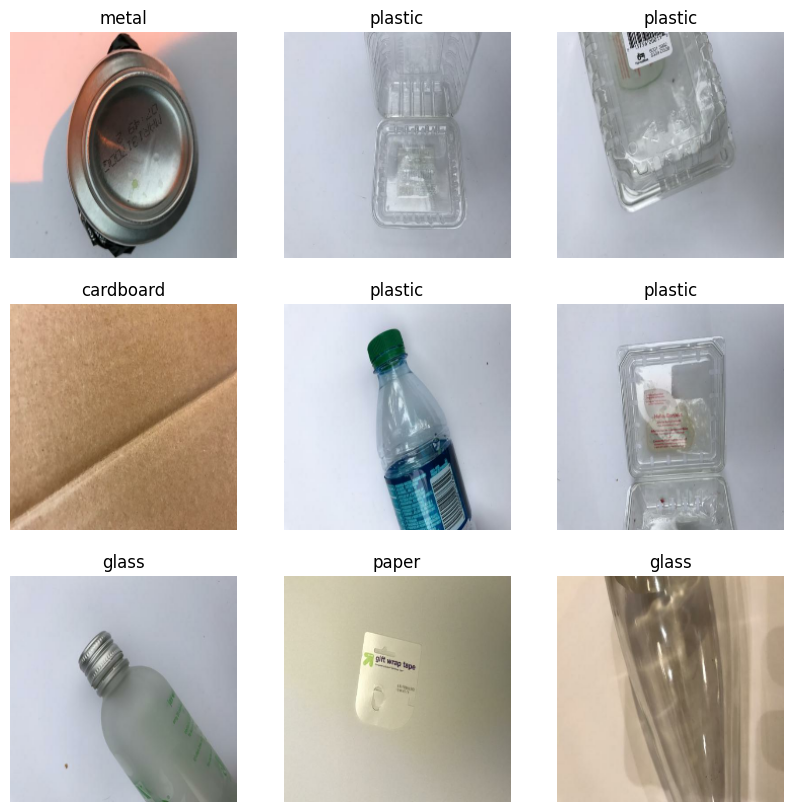

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))

# Assuming train_ds is your TensorFlow Dataset
for img, label in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

plt.show()


In [ ]:
##dataconfigure
## Create Test from valid
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))

Number of validation batches: 13
Number of test batches: 3
Number of train batches: 61


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

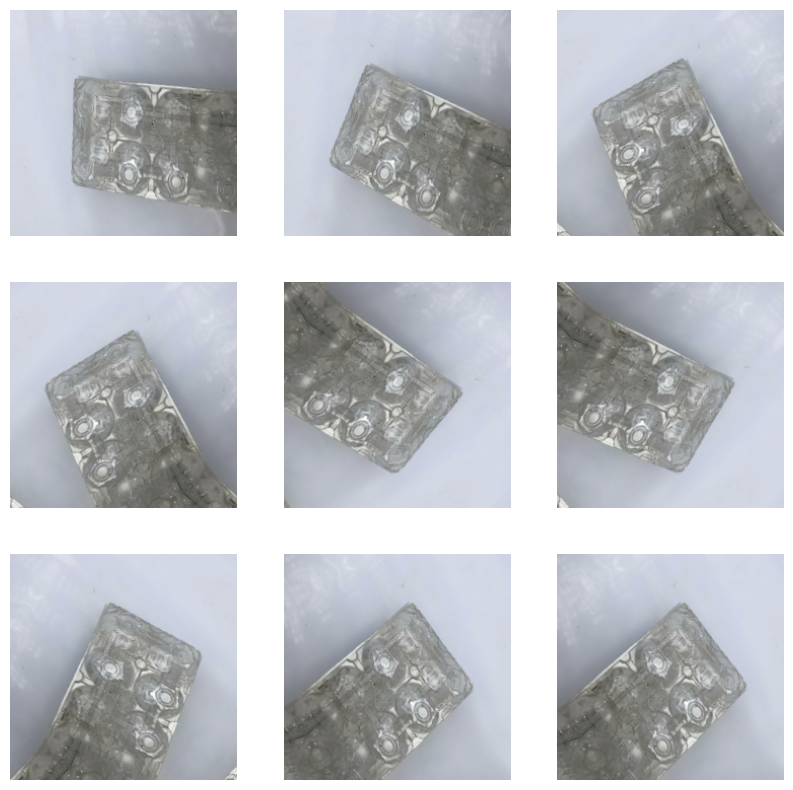

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

IMG_SHAPE = IMG_SIZE + [3]
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
#Freeze the layers in the base model
base_model.trainable=False

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Assuming you have already defined data_augmentation and folders

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add a Global Average Pooling layer
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
outputs = Dense(len(folders), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=outputs)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_learning_rate = 0.0001
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'] )
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
61/61 [==============================] - 1459s 24s/step - loss: 6.5456 - accuracy: 0.1871 - val_loss: 4.4027 - val_accuracy: 0.2641
Epoch 2/10
61/61 [==============================] - 1397s 23s/step - loss: 5.1461 - accuracy: 0.2472 - val_loss: 3.6190 - val_accuracy: 0.2974
Epoch 3/10
61/61 [==============================] - 1416s 23s/step - loss: 4.5965 - accuracy: 0.2718 - val_loss: 3.1596 - val_accuracy: 0.3385
Epoch 4/10
61/61 [==============================] - 1418s 23s/step - loss: 4.2170 - accuracy: 0.3042 - val_loss: 2.7930 - val_accuracy: 0.3821
Epoch 5/10
61/61 [==============================] - 1388s 23s/step - loss: 3.6743 - accuracy: 0.3314 - val_loss: 2.4006 - val_accuracy: 0.4462
Epoch 6/10
61/61 [==============================] - 1421s 23s/step - loss: 3.3825 - accuracy: 0.3715 - val_loss: 2.1256 - val_accuracy: 0.4564
Epoch 7/10
61/61 [==============================] - 1403s 23s/step - loss: 3.1452 - accuracy: 0.3895 - val_loss: 2.0628 - val_accuracy: 0.5000

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


Number of layers in the base model:  19


In [ ]:
base_learning_rate = 0.0001
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'] )
initial_epochs = 10
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
epochs=total_epochs,
initial_epoch=history.epoch[-1],
validation_data=val_ds)

Epoch 10/20
61/61 [==============================] - 2443s 40s/step - loss: 1.3081 - accuracy: 0.5858 - val_loss: 0.7559 - val_accuracy: 0.7103
Epoch 11/20
61/61 [==============================] - 2434s 40s/step - loss: 0.6345 - accuracy: 0.7744 - val_loss: 0.7019 - val_accuracy: 0.7385
Epoch 12/20
61/61 [==============================] - 2457s 40s/step - loss: 0.4111 - accuracy: 0.8535 - val_loss: 0.5686 - val_accuracy: 0.7974
Epoch 13/20
61/61 [==============================] - 2448s 40s/step - loss: 0.2519 - accuracy: 0.9111 - val_loss: 0.5331 - val_accuracy: 0.8026
Epoch 14/20
61/61 [==============================] - 2465s 40s/step - loss: 0.1761 - accuracy: 0.9383 - val_loss: 0.4793 - val_accuracy: 0.8333
Epoch 15/20
61/61 [==============================] - 2441s 40s/step - loss: 0.1277 - accuracy: 0.9599 - val_loss: 0.3900 - val_accuracy: 0.8590
Epoch 16/20
61/61 [==============================] - 2400s 39s/step - loss: 0.0803 - accuracy: 0.9805 - val_loss: 0.4257 - val_accuracy:

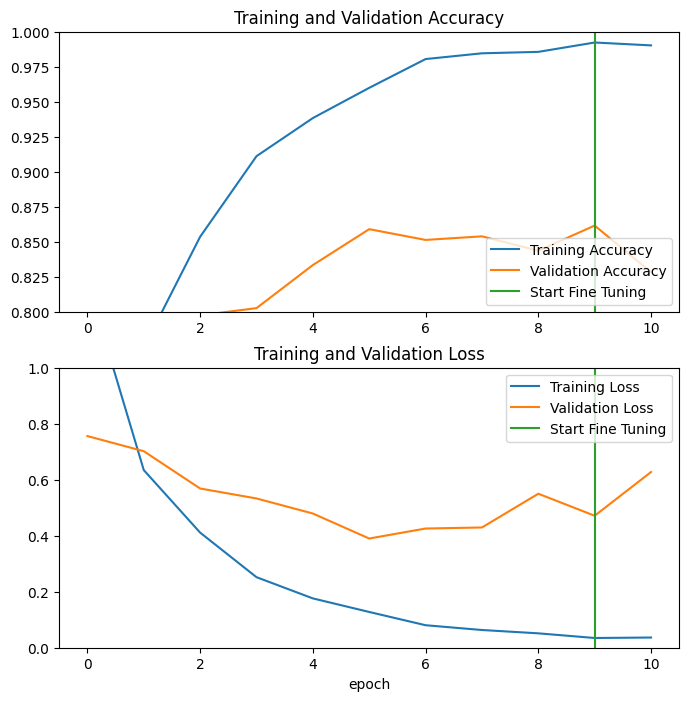

In [ ]:
acc = []
val_acc = []
loss = []
val_loss = []

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 61s 20s/step - loss: 1.0771 - accuracy: 0.7708
Test accuracy : 0.7708333134651184


1/1 [==============================] - 1s 566ms/step
Raw Probabilities: [0.2791939  0.05390152 0.37458518 0.1285279  0.14413638 0.01965519]


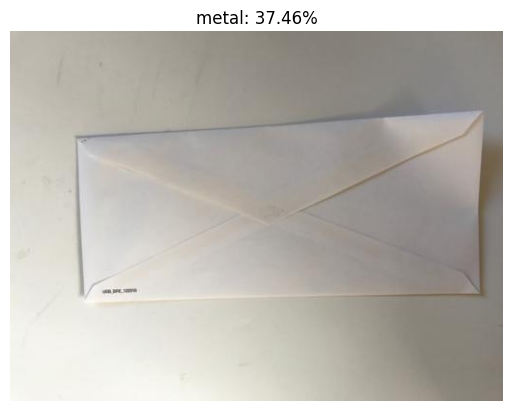

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming you have a list of labels, let's say 'class_labels'
class_labels = ['cardboard', 'plastic', 'trash', 'glass', 'paper', 'metal']
lb = LabelBinarizer()
lb.fit(class_labels)

def predict_with_display(imagePath, model, lb):
    # Load and preprocess the image
    img = image.load_img(imagePath, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    proba = model.predict(img_array)[0]
    idx = np.argmax(proba)
    label = lb.classes_[idx]
    prediction_text = "{}: {:.2f}%".format(label, proba[idx] * 100)

    # Print raw probabilities
    print("Raw Probabilities:", proba)

    # Display the image and prediction
    img = mpimg.imread(imagePath)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.title(prediction_text)
    plt.show()

# Call the predict_with_display function
imagePath = "/content/drive/MyDrive/datagar/datagar/paper/paper119.jpg"
predict_with_display(imagePath, model, lb)


1/1 [==============================] - 1s 566ms/step
Raw Probabilities: [0.35766444 0.04487525 0.31739366 0.13893193 0.11922091 0.02191385]


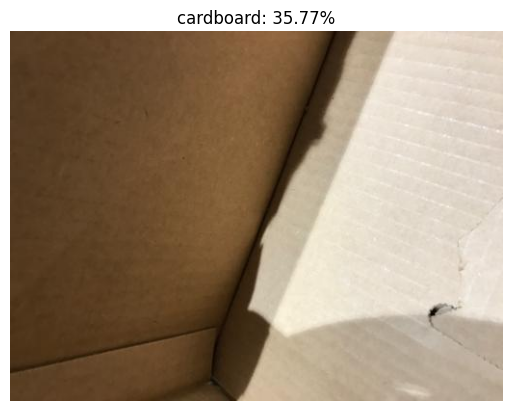

In [ ]:
# Call the predict_with_display function
imagePath = "/content/drive/MyDrive/datagar/datagar/cardboard/cardboard101.jpg"
predict_with_display(imagePath, model, lb)


1/1 [==============================] - 1s 1s/step
Raw Probabilities: [0.34207016 0.04560411 0.3310358  0.11269145 0.14019951 0.0283989 ]


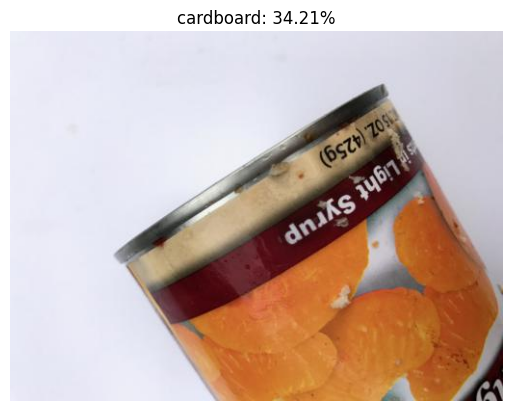

In [ ]:
# Call the predict_with_display function
imagePath = "/content/drive/MyDrive/datagar/datagar/metal/metal112.jpg"
predict_with_display(imagePath, model, lb)
